# Conducción de Calor en 2D

**Objetivo General**
- Resolver numérica y computacionalmente la ecuación de conducción de calor en dos dimensiones.

**Objetivos particulares**
- Definir los parámetros físicos y numéricos.
- Definir la malla del dominio.
- Definir la temperatura inicial junto con sus condiciones de frontera y graficarla sobre la malla.
- Definir el sistema lineal y resolverlo.
- Graficar la solución.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hecompa_FD2D as fd2
import macti.visual as mvis

## Parámetros físicos y numéricos

In [2]:
# Tamaño del dominio
Lx = 1.0
Ly = 1.0
k = 1.0
# Número de nodos en cada eje
Nx = 4
Ny = 4

# Número total de nodos en cada eje incluyendo las fronteras
NxT = Nx + 2
NyT = Ny + 2

# Número total de nodos
NT = NxT * NyT

# Número total de incógnitas
N = Nx * Ny

# Tamaño de la malla en cada dirección
hx = Lx / (Nx+1)
hy = Ly / (Ny+1)

# Coordenadas de la malla
xn = np.linspace(0,Lx,NxT)
yn = np.linspace(0,Ly,NyT)

# Generación de una rejilla
xg, yg = np.meshgrid(xn, yn, indexing='ij')

In [3]:
print('Total de nodos en x = {}, en y = {}'.format(NxT, NyT))
print('Total de incógnitas = {}'.format(N))
print('Coordenadas en x : {}'.format(xn))
print('Coordenadas en y : {}'.format(yn))
print('hx = {}, hy = {}'.format(hx, hy))

Total de nodos en x = 6, en y = 6
Total de incógnitas = 16
Coordenadas en x : [0.  0.2 0.4 0.6 0.8 1. ]
Coordenadas en y : [0.  0.2 0.4 0.6 0.8 1. ]
hx = 0.2, hy = 0.2


### Graficación de la malla del dominio

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def set_axes(ax):
    """
    Configura la razón de aspecto, quita las marcas de los ejes y el marco.
    
    Parameters
    ----------
    ax: axis
    Ejes que se vana configurar.
    """
    ax.set_aspect('equal') 
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
def plot_mesh(ax, xg, yg):
    """
    Dibuja la malla del dominio.
    
    Paramters
    ---------
    ax: axis
    Son los ejes donde se dibujará la malla.
    
    xn: np.array
    Coordenadas en x de la malla.
    
    yn: np.array
    Coordenadas en y de la malla.
    """
    set_axes(ax)
    
    xn = xg[:,0]
    yn = yg[0,:]
    
    for xi in xn:
        ax.vlines(xi, ymin=yn[0], ymax=yn[-1], lw=0.5, color='darkgray')
        
    for yi in yn:
        ax.hlines(yi, xmin=xn[0], xmax=xn[-1], lw=0.5, color='darkgray')
        
    ax.scatter(xg,yg, marker='.', color='darkgray')
    
def plot_frame(ax, xn, yn, lw = 0.5, color = 'k'):
    """
    Dibuja el recuadro de la malla.
    
    Paramters
    ---------
    ax: axis
    Son los ejes donde se dibujará la malla.
    
    xn: np.array
    Coordenadas en x de la malla.
    
    yn: np.array
    Coordenadas en y de la malla.
    """
    set_axes(ax)
    
    # Dibujamos dos líneas verticales
    ax.vlines(xn[0], ymin=yn[0], ymax=yn[-1], lw = lw, color=color)
    ax.vlines(xn[-1], ymin=yn[0], ymax=yn[-1], lw = lw, color=color)

    # Dibujamos dos líneas horizontales
    ax.hlines(yn[0], xmin=xn[0], xmax=xn[-1], lw = lw, color=color)
    ax.hlines(yn[-1], xmin=xn[0], xmax=xn[-1], lw = lw, color=color)

def set_canvas(ax, Lx, Ly):
    """
    Configura un lienzo para hacer las gráficas más estéticas.
    
    Parameters
    ----------
    ax: axis
    Son los ejes que se van a configurar.
    
    Lx: float
    Tamaño del dominio en dirección x.
    
    Ly: float
    Tamaño del dominio en dirección y.
    
    Returns
    -------
    cax: axis
    Eje donde se dibuja el mapa de color.
    """
    set_axes(ax)

    lmax = max(Lx,Ly)
    offx = lmax * 0.01
    offy = lmax * 0.01
    ax.set_xlim(-offx, Lx+offx)
    ax.set_ylim(-offy, Ly+offy)
    ax.grid(False)
    
    ax.set_aspect('equal')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "5%", pad="3%")
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines['bottom'].set_visible(False)
    cax.spines['left'].set_visible(False)
    
    return cax

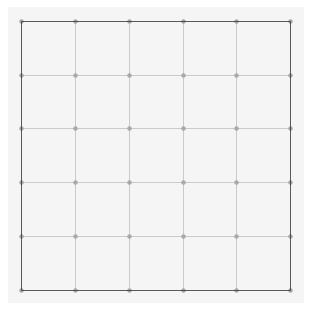

In [5]:
fig = plt.figure()
ax = plt.gca()

# Ejecutamos la función plot_mesh(...)
plot_mesh(ax, xg, yg)

# Dibujamos el recuadro con la función plot_fame(...)
plot_frame(ax, xn, yn)

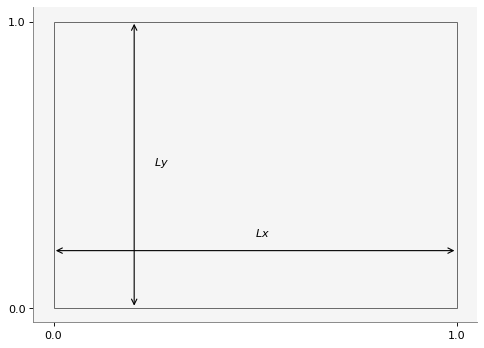

In [6]:
vis = mvis.Plotter(1,1)

vis.draw_domain(1, xg, yg)

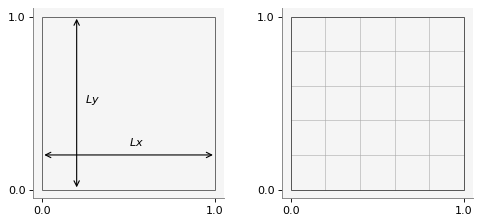

In [7]:
vis = mvis.Plotter(1,2,[dict(aspect='equal'), dict(aspect='equal')])

vis.draw_domain(1, xg, yg)
vis.plot_mesh2D(2, xg, yg)
vis.plot_frame(2, xg, yg)

## Campo de temperaturas y sus condiciones de frontera

In [8]:
# Definición de un campo escalar en cada punto de la malla
T = np.zeros((NxT, NyT))

# Condiciones de frontera
TB = 1.0
TT = -1.0

T[0 , :] = 0.0 # LEFT
T[-1, :] = 0.0 # RIGHT
T[: , 0] = TB  # BOTTOM
T[: ,-1] = TT  # TOP

print('Campo escalar T ({}):\n {}'.format(T.shape, T))

Campo escalar T ((6, 6)):
 [[ 1.  0.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0. -1.]
 [ 1.  0.  0.  0.  0. -1.]]


### Graficación del campo escalar sobre la malla

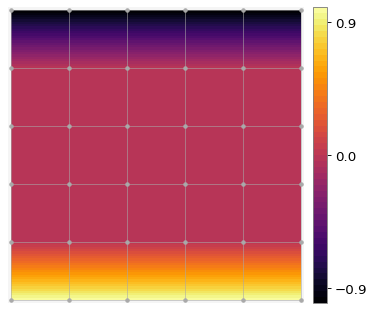

In [9]:
fig = plt.figure()
ax = plt.gca()
cax = set_canvas(ax, Lx, Ly)

c = ax.contourf(xg, yg, T, levels=50, cmap='inferno')
plot_mesh(ax, xg, yg)
fig.colorbar(c, cax=cax, ticks=[-0.9, 0.0, 0.9])
plt.show()

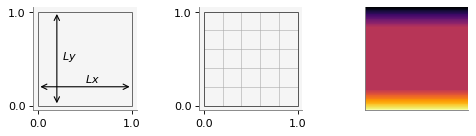

In [10]:
vis = mvis.Plotter(1,3,[dict(aspect='equal'), dict(aspect='equal'), dict(aspect='equal')])

vis.draw_domain(1, xg, yg)
vis.plot_mesh2D(2, xg, yg)
vis.plot_frame(2, xg, yg)
vis.contourf(3, xg, yg, T, levels=50, cmap='inferno')
vis.show()

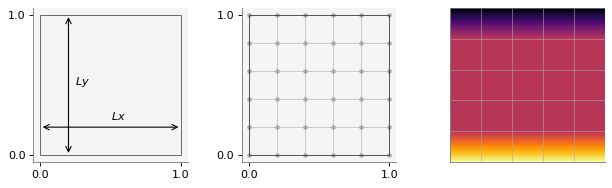

In [13]:
vis = mvis.Plotter(1,3,[dict(aspect='equal'), dict(aspect='equal'), dict(aspect='equal')],
                  dict(figsize=(8,16)))

vis.draw_domain(1, xg, yg)
vis.plot_mesh2D(2, xg, yg, nodeson=True)
vis.plot_frame(2, xg, yg)
vis.contourf(3, xg, yg, T, levels=50, cmap='inferno')
vis.plot_mesh2D(3,xg, yg)
vis.show()

### Campo vectorial

In [14]:
qx = np.zeros((Nx+2, Ny+2))
qy = qx.copy()

for i in range(1,Nx+1):
    for j in range(1,Ny+1):
        qx[i,j] = -k * (T[i+1,j] - T[i-1,j]) / 2 * hx
        qy[i,j] = -k * (T[i,j+1] - T[i,j-1]) / 2 * hy

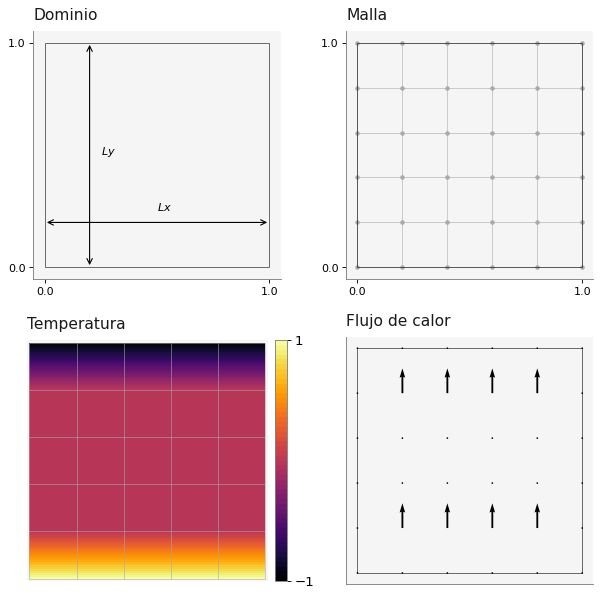

In [25]:
ax1 = dict(aspect='equal', title='Dominio')
ax2 = dict(aspect='equal', title='Malla')
ax3 = dict(aspect='equal', title='Temperatura')
ax4 = dict(aspect='equal', title='Flujo de calor')

vis = mvis.Plotter(2,2,[ax1, ax2, ax3, ax4],
                  dict(figsize=(8,8)))

vis.draw_domain(1, xg, yg)
vis.plot_mesh2D(2, xg, yg, nodeson=True)
vis.plot_frame(2, xg, yg)

cax3 = vis.set_canvas(3,Lx,Ly)
c = vis.contourf(3, xg, yg, T, levels=50, cmap='inferno')
vis.fig.colorbar(c, cax=cax3, ticks = [T.min(), T.max()], shrink=0.5, orientation='vertical')
vis.plot_mesh2D(3, xg, yg)

vis.plot_frame(4, xg, yg)
vis.quiver(4, xg, yg, qx, qy, scale=1)
vis.show()

## Sistema lineal

In [26]:
import FDM
# La matriz del sistema. Usamos la función predefinida buildMatrix2D()
A = FDM.buildMatrix2D(Nx,Ny,-4)
A

array([[-4.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 1., -4.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  1., -4.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  1., -4.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., -4.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  1., -4.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  1., -4.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  1., -4.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -4.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1., -4.,  1.,  0.,  0.,
         1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0

In [27]:
# RHS
b = np.zeros((Nx,Ny))
b[:, 0] -= TB  # BOTTOM
b[:,-1] -= TT  # TOP
b

array([[-1.,  0.,  0.,  1.],
       [-1.,  0.,  0.,  1.],
       [-1.,  0.,  0.,  1.],
       [-1.,  0.,  0.,  1.]])

## Solución del sistema

Revisamos el formato del vector b

In [29]:
b.shape

(4, 4)

El vector debe ser de una sola dimensión:

In [30]:
b.flatten()

array([-1.,  0.,  0.,  1., -1.,  0.,  0.,  1., -1.,  0.,  0.,  1., -1.,
        0.,  0.,  1.])

In [31]:
# Calculamos la solución.
T_temp = np.linalg.solve(A, b.flatten())
T_temp

array([ 0.40909091,  0.11363636, -0.11363636, -0.40909091,  0.52272727,
        0.15909091, -0.15909091, -0.52272727,  0.52272727,  0.15909091,
       -0.15909091, -0.52272727,  0.40909091,  0.11363636, -0.11363636,
       -0.40909091])

In [32]:
T_temp.shape

(16,)

Colocamos la solución en el campo escalar T de manera adecuada

In [33]:
T[1:-1,1:-1] = T_temp.reshape(Nx,Ny)
T

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.        ],
       [ 1.        ,  0.40909091,  0.11363636, -0.11363636, -0.40909091,
        -1.        ],
       [ 1.        ,  0.52272727,  0.15909091, -0.15909091, -0.52272727,
        -1.        ],
       [ 1.        ,  0.52272727,  0.15909091, -0.15909091, -0.52272727,
        -1.        ],
       [ 1.        ,  0.40909091,  0.11363636, -0.11363636, -0.40909091,
        -1.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.        ]])

In [35]:
qx = np.zeros((Nx+2, Ny+2))
qy = qx.copy()

for i in range(1,Nx+1):
    for j in range(1,Ny+1):
        qx[i,j] = -k * (T[i+1,j] - T[i-1,j]) / 2 * hx
        qy[i,j] = -k * (T[i,j+1] - T[i,j-1]) / 2 * hy

### Gráfica de la solución

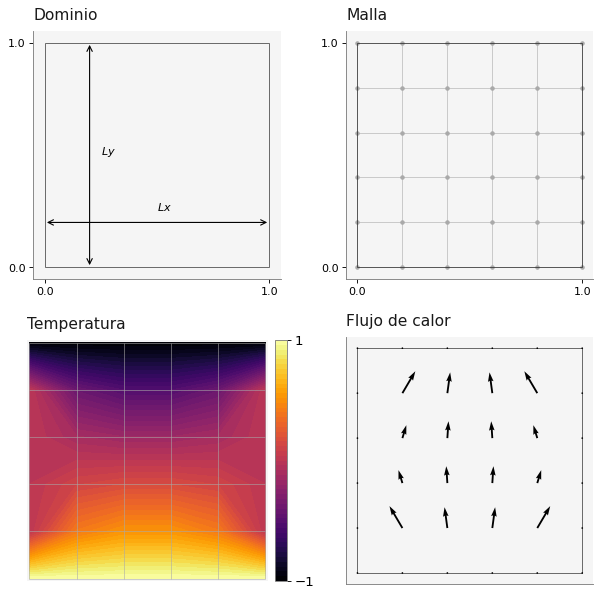

In [36]:
vis = mvis.Plotter(2,2,[ax1, ax2, ax3, ax4],
                  dict(figsize=(8,8)))

vis.draw_domain(1, xg, yg)
vis.plot_mesh2D(2, xg, yg, nodeson=True)
vis.plot_frame(2, xg, yg)

cax3 = vis.set_canvas(3,Lx,Ly)
c = vis.contourf(3, xg, yg, T, levels=50, cmap='inferno')
vis.fig.colorbar(c, cax=cax3, ticks = [T.min(), T.max()], shrink=0.5, orientation='vertical')
vis.plot_mesh2D(3, xg, yg)

vis.plot_frame(4, xg, yg)
vis.quiver(4, xg, yg, qx, qy, scale=1)
vis.show()

### Interactivo

In [48]:
def heat_cond(Lx, Ly, Nx, Ny):
    # Número total de nodos en cada eje incluyendo las fronteras
    NxT = Nx + 2
    NyT = Ny + 2
    
    # Número total de nodos
    NT = NxT * NyT
    
    # Número total de incógnitas
    N = Nx * Ny
    
    # Tamaño de la malla en cada dirección
    hx = Lx / (Nx+1)
    hy = Ly / (Ny+1)
    
    # Coordenadas de la malla
    xn = np.linspace(0,Lx,NxT)
    yn = np.linspace(0,Ly,NyT)
    
    # Generación de una rejilla
    xg, yg = np.meshgrid(xn, yn, indexing='ij')

    # Definición de un campo escalar en cada punto de la malla
    T = np.zeros((NxT, NyT))
    
    # Condiciones de frontera
    TB = 1.0
    TT = -1.0
    
    T[0 , :] = 0.0 # LEFT
    T[-1, :] = 0.0 # RIGHT
    T[: , 0] = TB  # BOTTOM
    T[: ,-1] = TT  # TOP

    # La matriz del sistema. Usamos la función predefinida buildMatrix2D()
    A = FDM.buildMatrix2D(Nx,Ny,-4)

    # RHS
    b = np.zeros((Nx,Ny))
    b[:, 0] -= TB  # BOTTOM
    b[:,-1] -= TT  # TOP

    # Calculamos la solución.
    T[1:-1,1:-1] = np.linalg.solve(A, b.flatten()).reshape(Nx,Ny)

    qx = np.zeros((Nx+2, Ny+2))
    qy = qx.copy()
    
    for i in range(1,Nx+1):
        for j in range(1,Ny+1):
            qx[i,j] = -k * (T[i+1,j] - T[i-1,j]) / 2 * hx
            qy[i,j] = -k * (T[i,j+1] - T[i,j-1]) / 2 * hy


    ax1 = dict(aspect='equal', title='Dominio')
    ax2 = dict(aspect='equal', title='Malla')
    ax3 = dict(aspect='equal', title='Temperatura')
    ax4 = dict(aspect='equal', title='Flujo de calor')

    vis = mvis.Plotter(2,2,[ax1, ax2, ax3, ax4],
                      dict(figsize=(8,8)))
    
    vis.draw_domain(1, xg, yg)
    vis.plot_mesh2D(2, xg, yg, nodeson=True)
    vis.plot_frame(2, xg, yg)
    
    cax3 = vis.set_canvas(3,Lx,Ly)
    c = vis.contourf(3, xg, yg, T, levels=50, cmap='inferno')
    vis.fig.colorbar(c, cax=cax3, ticks = [T.min(), T.max()], shrink=0.5, orientation='vertical')
    vis.plot_mesh2D(3, xg, yg)
    
    vis.plot_frame(4, xg, yg)
    vis.quiver(4, xg, yg, qx, qy, scale=1)
    vis.show()

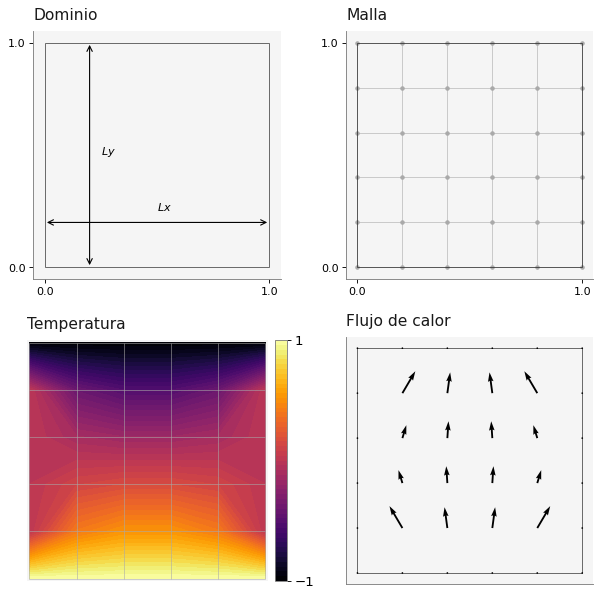

In [52]:
heat_cond(Lx=1, Ly=1, Nx=4, Ny=4)

In [42]:
import ipywidgets as widgets

In [53]:
widgets.interact(heat_cond, Lx = (1,3,1), Ly = (1,3,1), Nx = (4, 8, 1), Ny = (4, 8, 1))

interactive(children=(IntSlider(value=2, description='Lx', max=3, min=1), IntSlider(value=2, description='Ly',…

<function __main__.heat_cond(Lx, Ly, Nx, Ny)>